# Transformer

In [590]:
import math 
import pandas as pd
import torch
from torch import nn 
from d2l import torch as d2l
from IPython.display import Image

Below is the transformer architecture from paper "Attention all you need". 

In [591]:
Image(url="Transformer_architecture.png", width=800, height=800)

#### Positionwise Feed-Forward Networks

In [592]:
class PositionWiseFFN(nn.Module):
	"""Positionwise feed-forward network"""

	def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
		super(PositionWiseFFN, self).__init__(**kwargs)
		self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
		self.relu = nn.ReLU()
		self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

	def forward(self, X):
		return self.dense2(self.relu(self.dense1(X)))

In [593]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()

PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)

In [594]:
# test (batch_size, sequence_positions, hidden_dimesions)

# extract one batch before feed-forward
print(ffn(torch.ones((2, 3, 4))[0]).shape)

# extract one batch after feed-forward
print(ffn(torch.ones((2, 3, 4)))[0].shape)

torch.Size([3, 8])
torch.Size([3, 8])


#### Residual connection and layer normalization

In [595]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)

# Compute mean and variance from 'X' in the training mode
print('layer norm: ', ln(X), '\nbatch norm: ', bn(X))

# batch norm is normalization across batch dimension
# layer norm is normalization across layer dimension 
# In sequence task, layer norm is preferred since we normalize along one sequence. This is more stable than batch norm when the sequences are of vairable lengths

layer norm:  tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm:  tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [596]:
# input: (batch_size, seq_length, features_dim)
# normalized shape is input.size()[1: ]
# the normalizing direction is features_dim -- nomalizing along second dimension

# X is input 
# Y is Multiattention(X)

class AddNorm(nn.Module):
	"""Residual connection followed by layer normalization with dropout implementation"""

	def __init__(self, normalized_shape, dropout, **kwargs):
		super(AddNorm, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)
		self.ln = nn.LayerNorm(normalized_shape)

	def forward(self, X, Y): 
		return self.ln(self.dropout(Y) + X)

In [597]:
# test 
add_norm = AddNorm([3, 4], dropout=0.5)
add_norm.eval()

AddNorm(
  (dropout): Dropout(p=0.5, inplace=False)
  (ln): LayerNorm((3, 4), eps=1e-05, elementwise_affine=True)
)

In [598]:
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

#### Encoder

In [599]:
# one block of encoder consists of multi-head self attention and positionwise feed-foward network, each follows by a Add&Norm

class EncoderBlock(nn.Module):
	"""Transformer encoder block."""

	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(EncoderBlock, self).__init__(**kwargs)
		self.attention = d2l.MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout, use_bias=use_bias)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm2 = AddNorm(norm_shape, dropout)

	def forward(self, X, valid_lens):
		Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
		return self.addnorm2(Y, self.ffn(Y))

In [600]:
# test 

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2]) # same as batch size

# key_size = query_size = value_size = num_hiddens = 24
# norm_shape = each batch size
# ffn_num_input = 24
# ffn_num_hiddens = 48
# num_heads = 8
# dropout = 0.5
# use_bias = False
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval() # summary of blocks

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_k): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_v): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_o): LazyLinear(in_features=0, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

In [601]:
# Note all layers in encoder does not change the shape of output
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

#### Transformer encoder

In [602]:
# we can now stack the blocks of encoders
# we also need to rescale to learnable input embeddings by sqrt(embedding dim) to [-1, 1]. This is because each value of positional embeddding is [-1, 1]
# num_layers: number of blocks of encoder
# vocab_size: size of vocabulary dictionary

class TransformerEncoder(d2l.Encoder):
	"""Transformer encoder."""

	def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
		super(TransformerEncoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.embedding = nn.Embedding(vocab_size, num_hiddens) # here we randomly initialize a input embedding matrix 
		self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("Block"+str(i), EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=use_bias))
	
	def forward(self, X, valid_lens, *args):
		
		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self.attention_weights = [None] * len(self.blks) # create a attention weight list to hold attention weights at each block
		for i, blk in enumerate(self.blks):
			X = blk(X, valid_lens)
			self.attention_weights[i] = blk.attention.attention.attention_weights # the actual attention weights is stored in the ScaledDotAttention
		
		return X

In [603]:
# test

# vocab_size = 200
# num_layers = 2

encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (Block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): LazyLinear(in_features=0, out_features=24, bias=False)
        (W_k): LazyLinear(in_features=0, out_features=24, bias=False)
        (W_v): LazyLinear(in_features=0, out_features=24, bias=False)
        (W_o): LazyLinear(in_features=0, out_features=24, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addnorm2): AddNorm

In [604]:
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

#### Decoder

In [606]:
# self.i stores all previous representations

class DecoderBlock(nn.Module):
	"""The ith decoder block"""
	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
		super(DecoderBlock, self).__init__(**kwargs)
		self.i = i
		self.attention1 = d2l.MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.attention2 = d2l.MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm2 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm3 = AddNorm(norm_shape, dropout)

	def forward(self, X, state):
		# state: (encoder_output, encoder_valid_len, some info)
		enc_outputs, enc_valid_lens = state[0], state[1]

		if state[2][self.i] is None: # if nothing is stored previously, we use all X. This only occurs during training
			key_values = X
		else:
			key_values = torch.cat((state[2][self.i], X), axis=1) # we combine the previous with current X. This often occurs during prediction ------------------- ?potential issues
		state[2][self.i] = key_values

		if self.training: # True if training procedure applied
			batch_size, num_steps, _ = X.shape # (batch_size, previous_timesteps, hidden_dimension)
			dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1) # repeat to size (2, 1), this specifies how we mask each row in each minibatch
		else:
			dec_valid_lens = None # for prediction, we do not need mask, since we do not know what is after
		
		# main model
		# q, k, v as defined
		X2 = self.attention1(X, key_values, key_values, dec_valid_lens) # training: all X, but we mask all after, prediction: queries=current timestep repr, keys_values, all previous 
		Y = self.addnorm1(X, X2)
		Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # in the case encoder is masked 
		Z = self.addnorm2(Y, Y2)

		return self.addnorm3(Z, self.ffn(Z)), state # state here is passed as it was 

	# some additional notes: 
	# decoder consists of 2 functionality: training and prediction 

	# during training: we use the whole sequence but mask attention weights
	# The attention weights matrix has dimension (q, k) -- the second query will only get acess to the first 2 key
	# state[2] is [None]

	# during prediction: we only have current embedding -- 1 query 
	# the key-values combine current and all previous key-valuee to search for -- decoder self attention 


In [607]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape


torch.Size([2, 100, 24])

In [608]:
from matplotlib.pyplot import axis


A = torch.tensor([[1, 2]])
B = torch.tensor([[1, 2]])
print(A)
print(B)

C = torch.cat((A, B), axis=1)
print(C)

tensor([[1, 2]])
tensor([[1, 2]])
tensor([[1, 2, 1, 2]])


#### Transformer Decoder

In [609]:
class TransformerDecoder(d2l.AttentionDecoder):

	def __init__(self, vocab_size,  key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
		super(TransformerDecoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.num_layers = num_layers
		self.embedding = nn.Embedding(vocab_size, num_hiddens)
		self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("block"+str(i), DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
		self.dense = nn.Linear(num_hiddens, vocab_size)
		# prediction: we have (1, num_hiddens) --> (1, num_vocab_size)

	def init_state(self, enc_outputs, enc_valid_lens, *args):
		return [enc_outputs, enc_valid_lens, [None]*self.num_layers]

	def forward(self, X, state):
		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self._attention_weights = [[None] * len(self.blks) for _ in range(2)] # here we record attention from 2 attention module (2, i)
		for i, blk in enumerate(self.blks):

			X, state = blk(X, state)
			# Decoder self-attention weights
			self._attention_weights[0][i] = blk.attention1.attention.attention_weights
			# Encoder-decoder attention weights
			self._attention_weights[1][i] = blk.attention2.attention.attention_weights
		
		return self.dense(X), state

	def attention_weights(self):
		return self._attention_weights


In [610]:
# test 

num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32] # 32 corresponds to the dim of such number to normalize  

In [611]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [612]:
print(len(train_iter))
print(len(src_vocab))
print(len(tgt_vocab))

10
184
195


#### Encoder to Decoder architecture

In [613]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)  # feature representation from encoder
        dec_state = self.decoder.init_state(enc_outputs, *args) # use the feature representation from encoder to process a decoder init: (training--None), (prediction -- previous important information)
        return self.decoder(dec_X, dec_state)

#### The softmax cross-entropy loss with mask

In [614]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
	"""The softmax cross-entropy loss with masks."""
	# 'pred' shape: ('batch_size', 'num_steps', 'vocab_size')  ---> shape should be (0, 2, 1)
	# 'label' shape: ('batch_size', num_steps) --- each number is a number between 0 and vocab_size/prob
	# 'valid_len' shape: ('batch_size', )

	# "none" return same shape as 'label'
	
	# num_steps have to be the same 
	# during training, our labeled/pred length can be very long. We can restrict the length of each batch.
	# we ignore the irrelevant part
	def forward(self, pred, label, valid_len):
		weights = torch.ones_like(label)
		weights = d2l.sequence_mask(weights, valid_len)
		self.reduction = 'none'
		unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
		weighted_loss = (unweighted_loss * weights).mean(dim=1) # mean of each batch along num_steps
		return weighted_loss

In [615]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

#### Transformer training

In [616]:
# Here we enforce the first word <bos>

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.029, 4025.0 tokens/sec on cpu


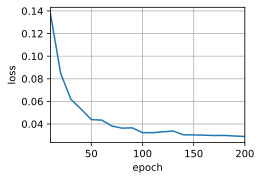

In [617]:
encoder = TransformerEncoder(
	len(src_vocab), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder = TransformerDecoder(
	len(tgt_vocab), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

#### Transformer prediction 

In [618]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)


    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):

        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [619]:
engs = ['go .']
# engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
